<a href="https://colab.research.google.com/github/Esandu-Meth-Obadaarachchi/HCHO-level-Time-series-forecasting/blob/main/DE_3_Analysis_and_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

2.15.0


In [13]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=8807170e83a0272a3d042ecd5ed13460e088d3c104a66f793b804896089a432e
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

In [14]:
import pyspark
import pyspark.sql  as pyspark_sql
import pyspark.sql.types as pyspark_types
import pyspark.sql.functions  as pyspark_functions
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col, regexp_replace, when
from pyspark.sql.types import StructType, StructField, DoubleType, StringType

In [2]:
from google.colab import drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import pandas as pd

# File paths for each DataFrame CSV file
colombo_full_csv_path = '/content/drive/MyDrive/data engineering CW/colombo_df_full.csv'
deniyaya_matara_full_csv_path = '/content/drive/MyDrive/data engineering CW/deniyaya_matara_df_full.csv'
nuwara_eliya_full_csv_path = '/content/drive/MyDrive/data engineering CW/nuwara_eliya_df_full.csv'
bibile_monaragala_full_csv_path = '/content/drive/MyDrive/data engineering CW/bibile_monaragala_df_full.csv'
kurunegala_full_csv_path = '/content/drive/MyDrive/data engineering CW/kurunegala_df_full.csv'
jaffna_full_csv_path = '/content/drive/MyDrive/data engineering CW/jaffna_df_full.csv'
kandy_full_csv_path = '/content/drive/MyDrive/data engineering CW/kandy_df_full.csv'

# Load each DataFrame from the CSV file
colombo_df = pd.read_csv(colombo_full_csv_path, header=0, index_col=0)
deniyaya_matara_df = pd.read_csv(deniyaya_matara_full_csv_path, header=0, index_col=0)
nuwara_eliya_df = pd.read_csv(nuwara_eliya_full_csv_path, header=0, index_col=0)
bibile_monaragala_df = pd.read_csv(bibile_monaragala_full_csv_path, header=0, index_col=0)
kurunegala_df = pd.read_csv(kurunegala_full_csv_path, header=0, index_col=0)
jaffna_df = pd.read_csv(jaffna_full_csv_path, header=0, index_col=0)
kandy_df = pd.read_csv(kandy_full_csv_path, header=0, index_col=0)

In [9]:
# Set index to 'Current Date'
colombo_df.set_index('Current Date', inplace=True)
deniyaya_matara_df.set_index('Current Date', inplace=True)
nuwara_eliya_df.set_index('Current Date', inplace=True)
bibile_monaragala_df.set_index('Current Date', inplace=True)
kurunegala_df.set_index('Current Date', inplace=True)
jaffna_df.set_index('Current Date', inplace=True)
kandy_df.set_index('Current Date', inplace=True)

In [10]:
colombo_df.head()

,Location,Next Date,HCHO reading,Specific Humidity,Relative Humidity,Precipitation,Temperature,Skin Temperature
Current Date,,,,,,,,
2019-01-01,Colombo Proper,2019-01-02,0.000197,15.62,80.00,0.12,24.80,25.29
2019-01-02,Colombo Proper,2019-01-03,0.000263,15.14,79.50,0.02,24.39,25.01
2019-01-03,Colombo Proper,2019-01-04,0.000099,14.77,78.50,0.01,24.17,24.73
2019-01-04,Colombo Proper,2019-01-05,0.000210,14.47,77.62,0.00,24.04,24.57
2019-01-05,Colombo Proper,2019-01-06,0.000179,16.05,81.50,0.03,24.87,25.33


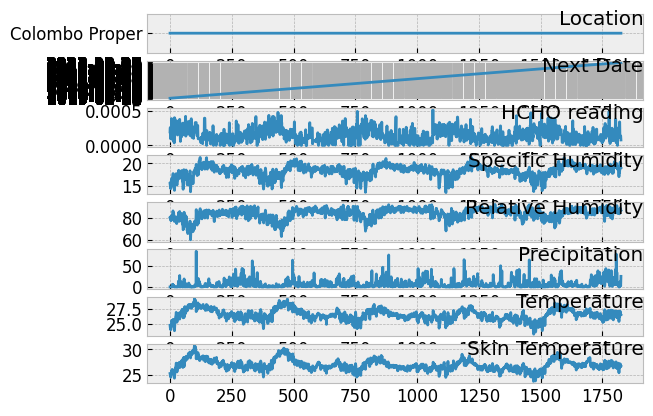

In [11]:
values = colombo_df.values
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
# plot each column
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(colombo_df.columns[group], y=0.5, loc='right')
    i += 1


plt.show()

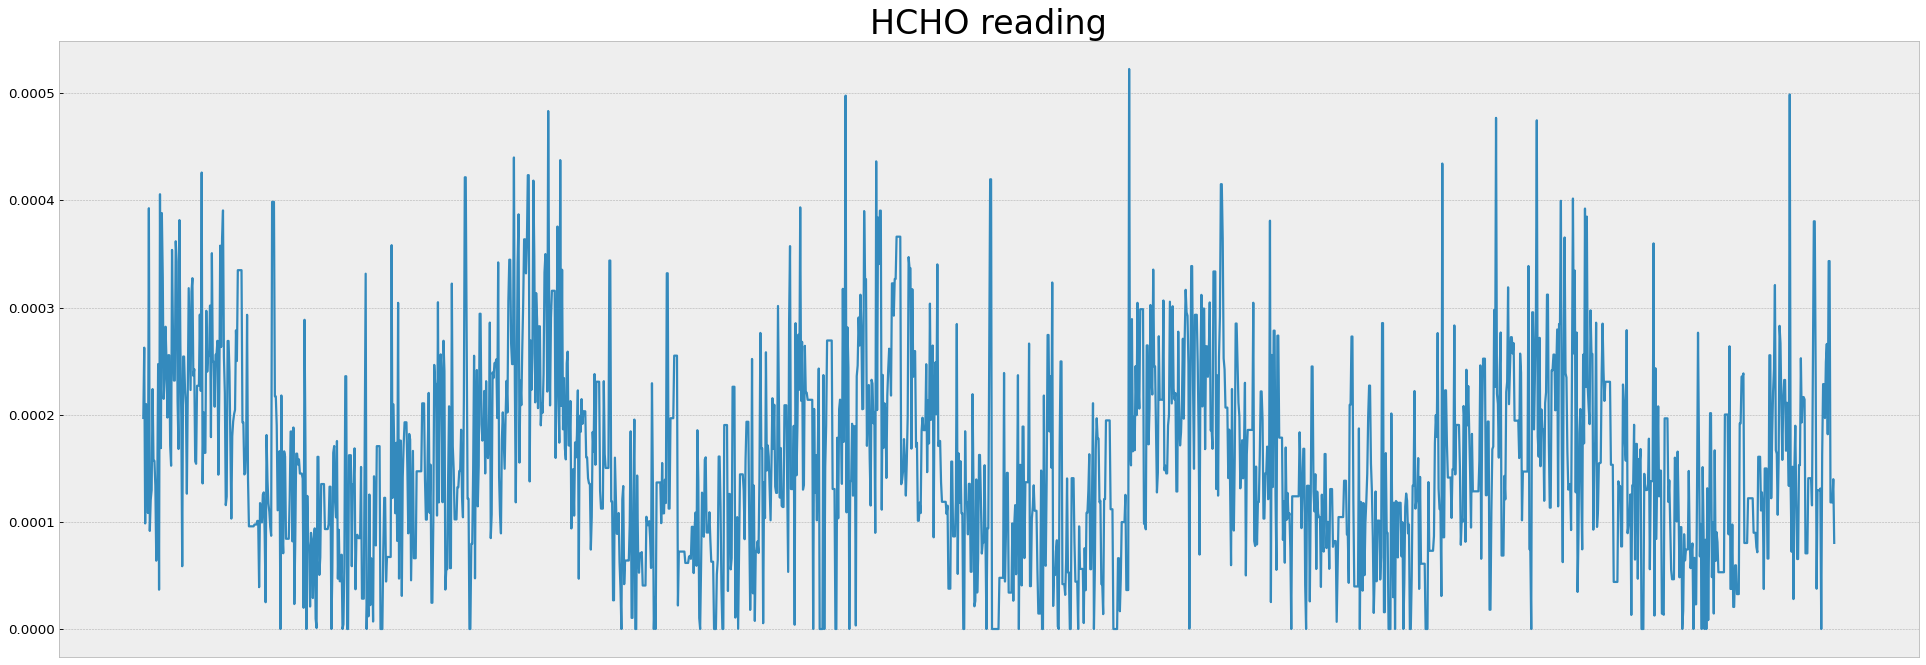

In [12]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('HCHO reading', fontsize=30)
plt.plot(colombo_df['HCHO reading'])
plt.xticks([])  # Remove x-axis ticks
plt.show()

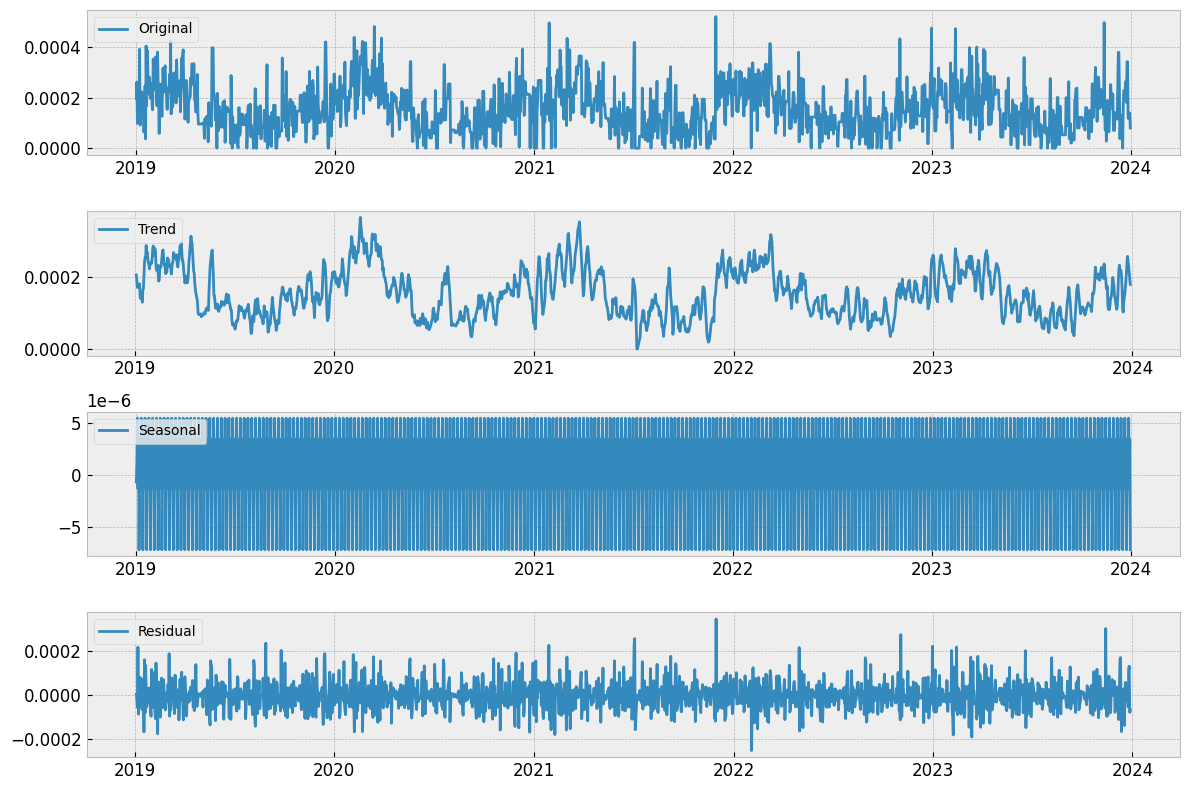

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming colombo_df has a 'Date' column as the index and 'HCHO reading' as the time series data

# Convert index to DatetimeIndex
colombo_df.index = pd.to_datetime(colombo_df.index)

# Perform seasonal decomposition
result = seasonal_decompose(colombo_df['HCHO reading'], model='additive')

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(result.observed, label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()



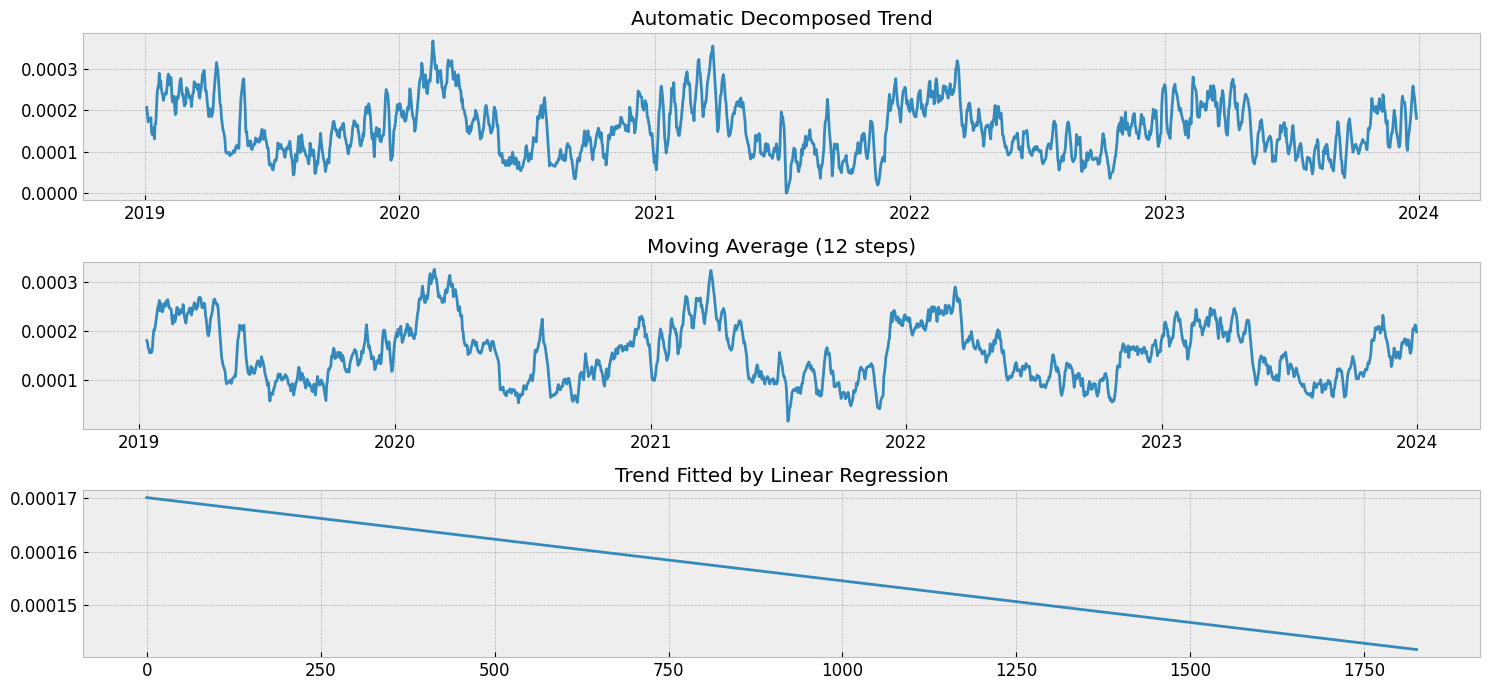

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Assuming colombo_df is your DataFrame containing the 'HCHO reading' data

# Automatic decomposition
result = seasonal_decompose(colombo_df['HCHO reading'], model='additive')

# Moving average
moving_avg = colombo_df['HCHO reading'].rolling(12).mean()

# Fit a linear regression model
X = np.arange(len(colombo_df)).reshape(-1, 1)
y = colombo_df['HCHO reading'].values
model = LinearRegression()
model.fit(X, y)
trend_lr = model.predict(X)

# Plotting
fig = plt.figure(figsize=(15, 7))
layout = (3, 1)
pm_ax = plt.subplot2grid(layout, (0, 0))
mv_ax = plt.subplot2grid(layout, (1, 0))
fit_ax = plt.subplot2grid(layout, (2, 0))

pm_ax.plot(result.trend, label="Automatic decomposed trend")
pm_ax.set_title("Automatic Decomposed Trend")

mv_ax.plot(moving_avg, label="Moving average (12 steps)")
mv_ax.set_title("Moving Average (12 steps)")

fit_ax.plot(trend_lr, label="Trend fitted by linear regression")
fit_ax.set_title("Trend Fitted by Linear Regression")

plt.tight_layout()
plt.show()


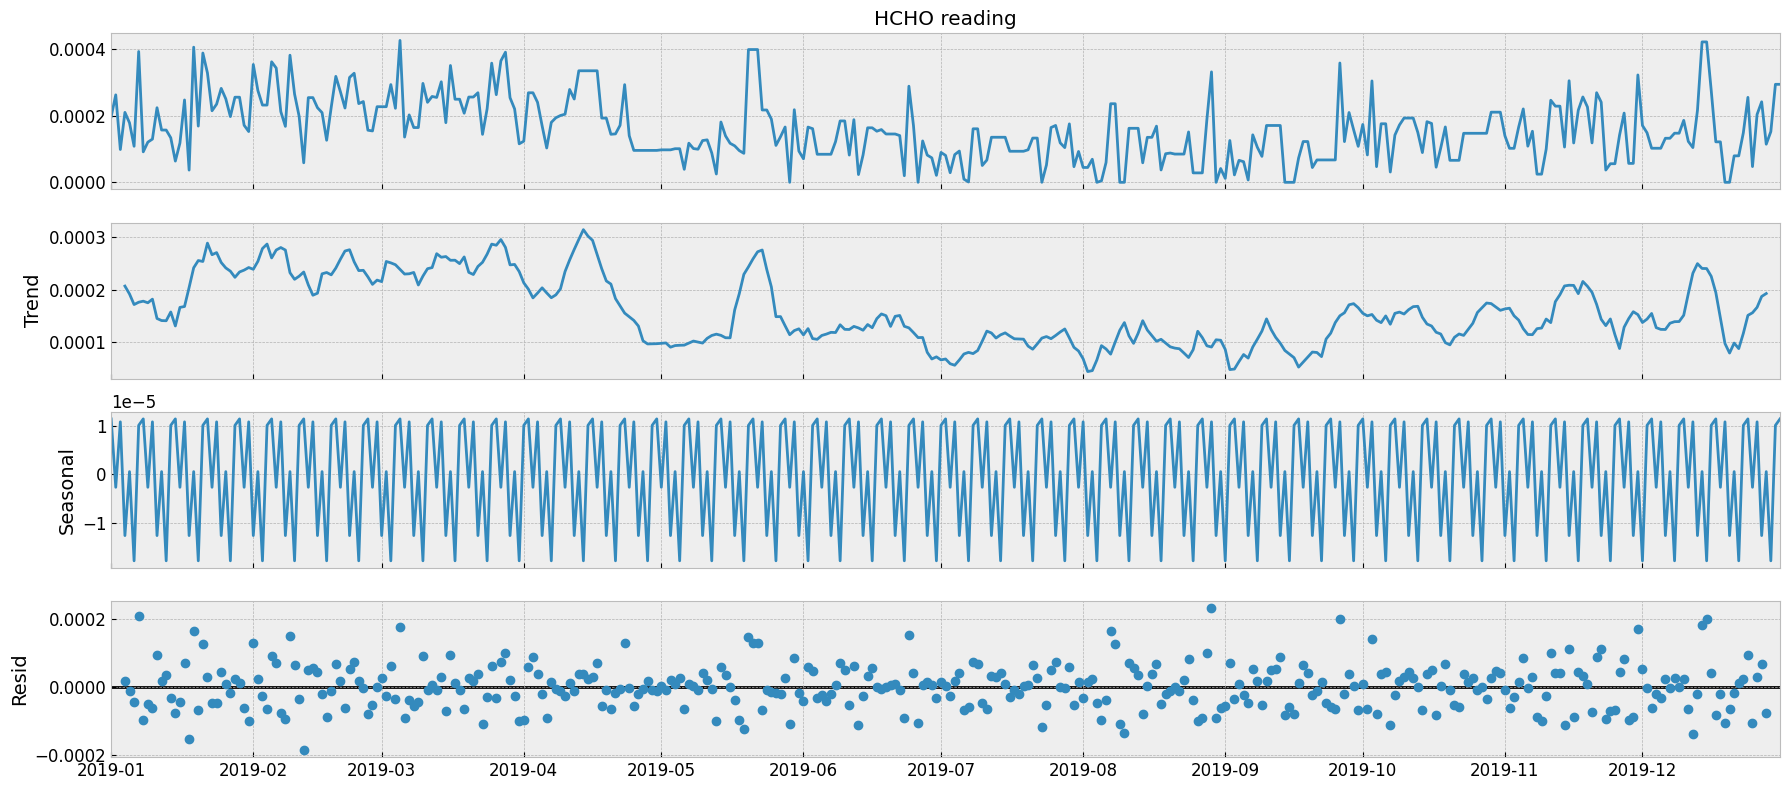

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import pandas as pd

# Assuming colombo_df is your DataFrame containing the 'HCHO reading' data

# Set figure size
plt.rcParams['figure.figsize'] = (18, 8)

# Extracting the first year of data
series = colombo_df['HCHO reading'][:365]

# Perform seasonal decomposition
result = seasonal_decompose(series, model='additive')

# Plot the decomposed components
result.plot()

# Show the plot
plt.show()

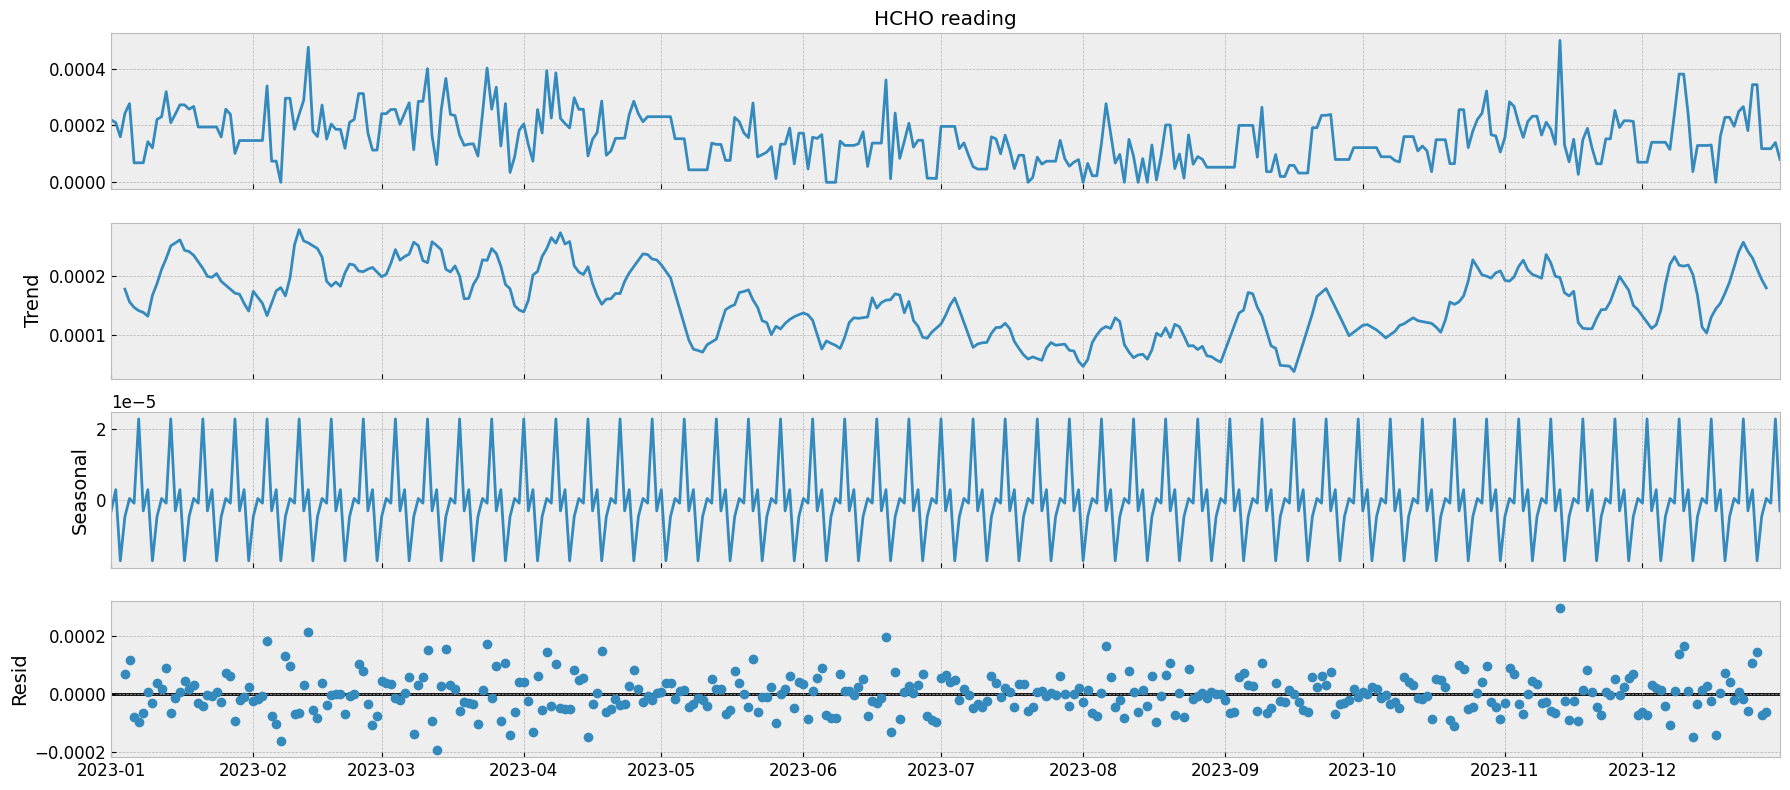

In [16]:
# Set figure size
plt.rcParams['figure.figsize'] = (18, 8)

# Extracting the last year of data
series = colombo_df['HCHO reading'][-365:]

# Perform seasonal decomposition
result = seasonal_decompose(series, model='additive')

# Plot the decomposed components
result.plot()

# Show the plot
plt.show()

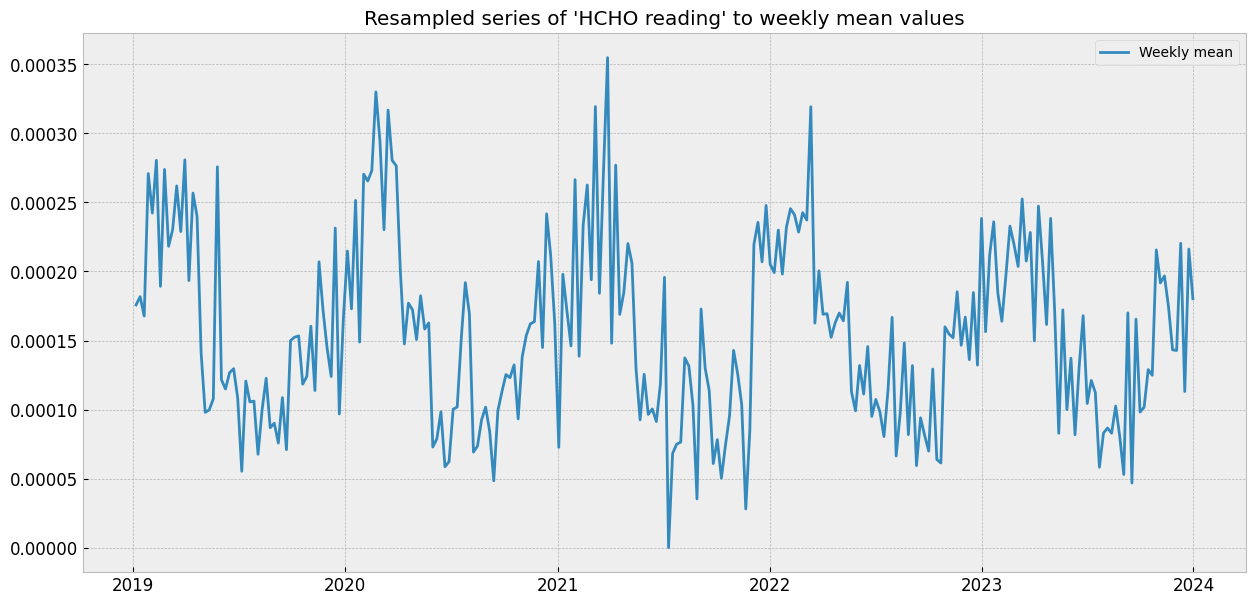

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming colombo_df is your DataFrame containing the 'HCHO reading' data

# Convert 'HCHO reading' column to numeric, coerce errors to NaN
colombo_df['HCHO reading'] = pd.to_numeric(colombo_df['HCHO reading'], errors='coerce')

# Resample your DataFrame to weekly mean values for the 'HCHO reading' column only
weekly_mean = colombo_df['HCHO reading'].resample('W').mean()

# Plot the weekly mean values
plt.figure(figsize=(15, 7))
plt.plot(weekly_mean, label='Weekly mean')
plt.title("Resampled series of 'HCHO reading' to weekly mean values")
plt.legend()
plt.show()



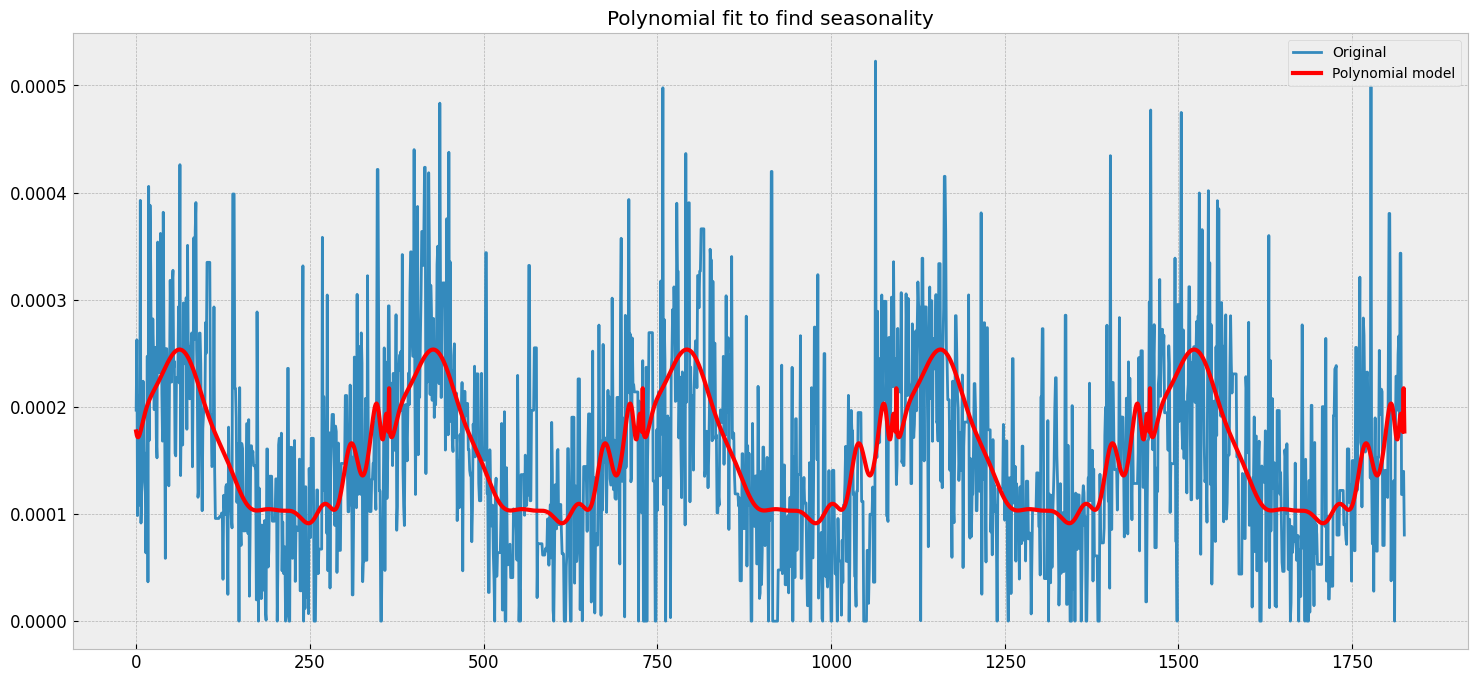

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming colombo_df is your DataFrame containing the 'HCHO reading' data

# Extracting the 'HCHO reading' column
series = colombo_df['HCHO reading'].values

# Define X values as days of the year (mod 365)
X = [i % 365 for i in range(0, len(series))]
y = series
degree = 100

# Fit polynomial
coef = np.polyfit(X, y, degree)

# Create curve
curve = np.polyval(coef, X)

# Plot curve over original data
plt.plot(series, label='Original')
plt.plot(curve, color='red', linewidth=3, label='Polynomial model')
plt.legend()
plt.title("Polynomial fit to find seasonality")
plt.show()


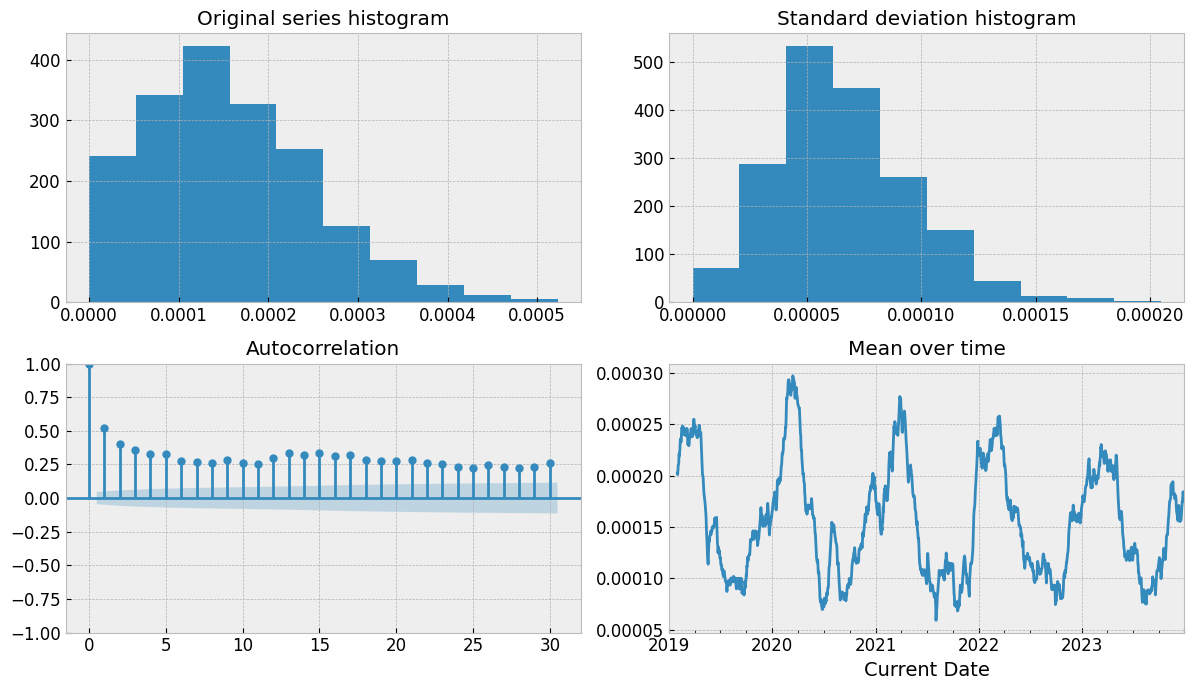

In [19]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Set up figure and subplots
fig = plt.figure(figsize=(12, 7))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

# Plot histogram of the original series
colombo_df['HCHO reading'].hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

# Plot autocorrelation
plot_acf(colombo_df['HCHO reading'], lags=30, ax=ac_ax)
ac_ax.set_title("Autocorrelation")

# Calculate rolling standard deviation
rolling_std = colombo_df['HCHO reading'].rolling(7).std()

# Plot histogram of the rolling standard deviation
rolling_std.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

# Calculate rolling mean
rolling_mean = colombo_df['HCHO reading'].rolling(30).mean()

# Plot rolling mean
rolling_mean.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


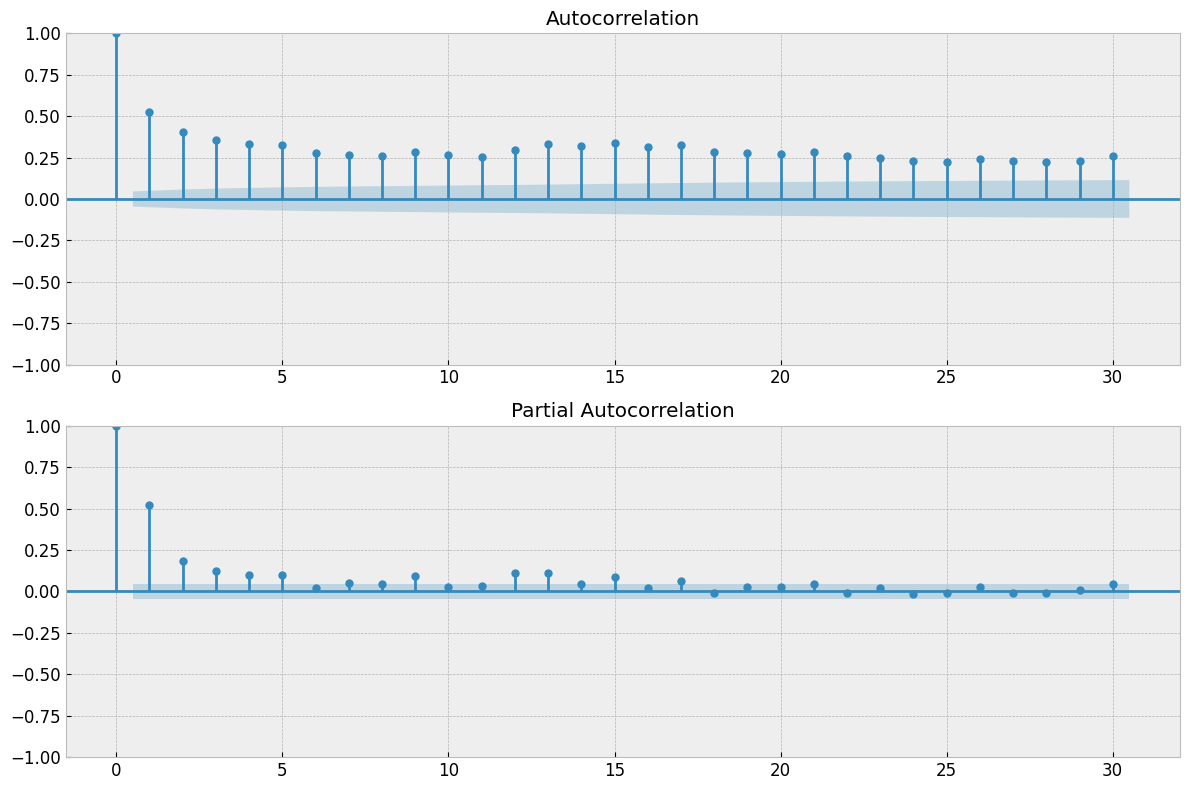

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Set up figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot autocorrelation
plot_acf(colombo_df['HCHO reading'], lags=30, ax=ax1)
ax1.set_title("Autocorrelation")

# Plot partial autocorrelation
plot_pacf(colombo_df['HCHO reading'], lags=30, ax=ax2)
ax2.set_title("Partial Autocorrelation")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


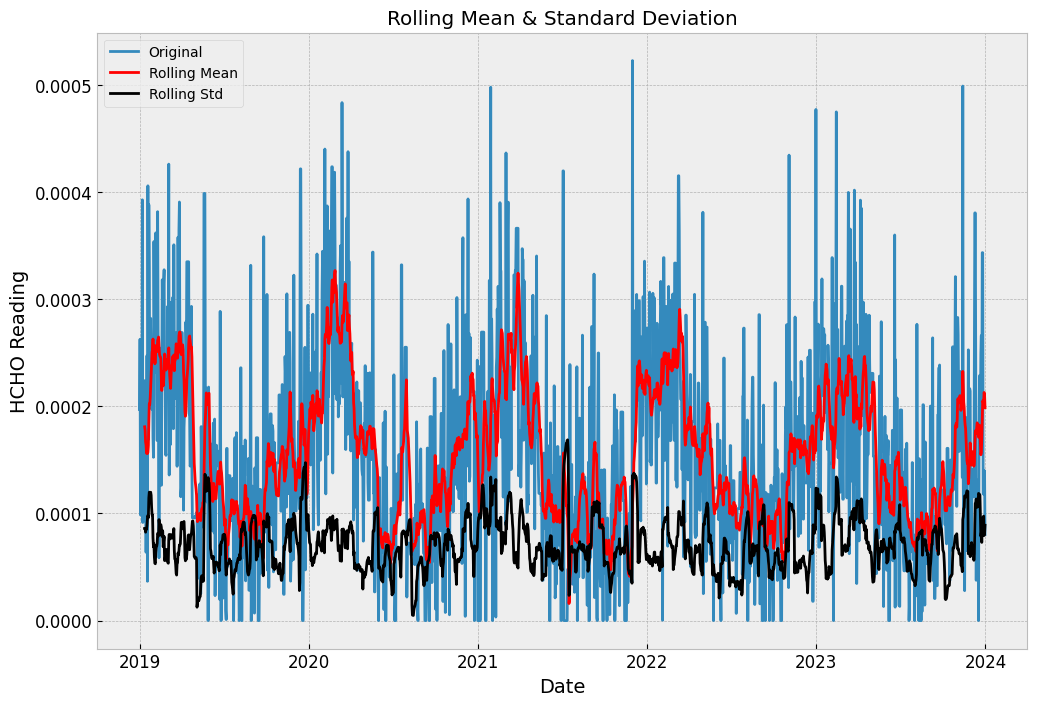

In [21]:
# Determine rolling statistics
rolmean = colombo_df['HCHO reading'].rolling(window=12).mean()
rolstd = colombo_df['HCHO reading'].rolling(window=12).std()

# Plot rolling statistics
plt.figure(figsize=(12, 8))
plt.plot(colombo_df['HCHO reading'], label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.show()


In [22]:
from statsmodels.tsa.stattools import adfuller

# Extract 'HCHO reading' data
X = colombo_df['HCHO reading'].values

# Perform Augmented Dickey-Fuller test
result = adfuller(X)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.2572111126082035
p-value: 0.0005264219736638642
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


DF Statistic: -4.2572111126082035
This is the test statistic calculated by the ADF test. It is used to determine whether the null hypothesis of non-stationarity can be rejected. In this case, the ADF statistic is negative, indicating that the time series data is likely to be stationary.
p-value: 0.0005264219736638642
This is the p-value associated with the ADF statistic. It represents the probability of observing the ADF statistic if the null hypothesis of non-stationarity is true. In this case, the p-value is significantly less than 0.05 (commonly used significance level), indicating strong evidence against the null hypothesis. Therefore, we can reject the null hypothesis and conclude that the data is stationary.
Critical Values:
These are the critical values at different levels of significance (1%, 5%, and 10%). They represent thresholds for the ADF statistic beyond which we can reject the null hypothesis. In this case, the ADF statistic is lower than all the critical values, further supporting the rejection of the null hypothesis.

In [23]:
# Set the split date
split_date = '2023-01-01'

# Split the DataFrame into training and testing sets
colombo_training = colombo_df.loc[colombo_df.index <= split_date]
colombo_test = colombo_df.loc[colombo_df.index > split_date]

# Print the lengths of the training and testing sets
print(f"{len(colombo_training)} days of training data \n {len(colombo_test)} days of testing data ")

# Save the training and testing sets to CSV files
colombo_training.to_csv('/content/drive/MyDrive/data engineering CW/colombo_training.csv')
colombo_test.to_csv('/content/drive/MyDrive/data engineering CW/colombo_test.csv')


1462 days of training data 
 364 days of testing data 


In [27]:
import xgboost as xgb

from fbprophet import Prophet
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from matplotlib import pyplot as plt
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

from utils.metrics import evaluate

ModuleNotFoundError: No module named 'fbprophet'

In [28]:
from tqdm import tqdm  # Import tqdm for progress bar
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

# Initialize dictionaries to store results and predictions
resultsDict = {}
predictionsDict = {}

# Walk through the test data, training and predicting 1 day ahead for all the test data
index = len(colombo_training)
yhat = []

for t in tqdm(range(len(colombo_test['HCHO reading']))):
    temp_train = colombo_df['HCHO reading'][:len(colombo_training)+t]
    model = AutoReg(temp_train, lags=1)  # You can adjust the number of lags as needed
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat.append(predictions[0])

yhat = pd.Series(yhat, index=colombo_test.index)
resultsDict['AR'] = mean_squared_error(colombo_test['HCHO reading'], yhat)
predictionsDict['AR'] = yhat


100%|██████████| 364/364 [00:06<00:00, 56.19it/s]


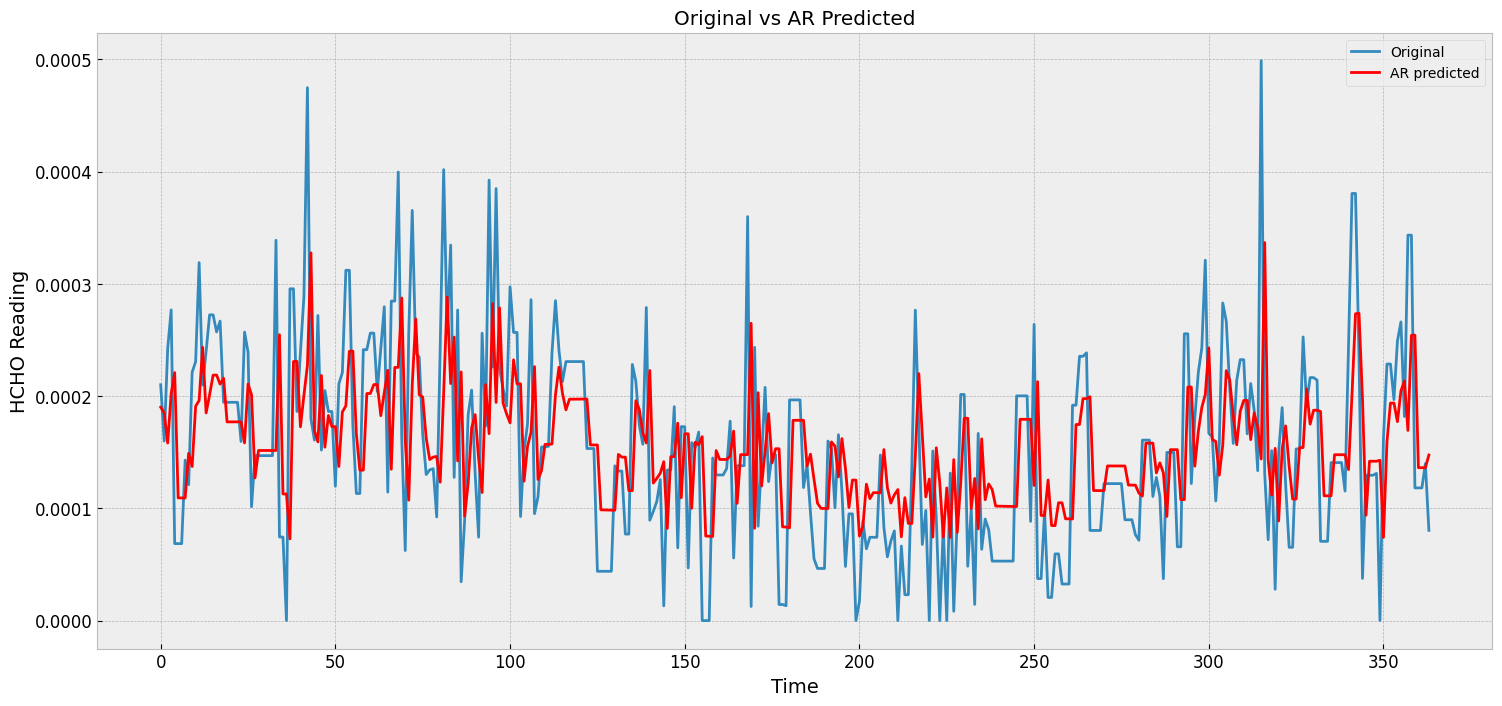

In [29]:
import matplotlib.pyplot as plt

# Plot the results
plt.plot(colombo_test['HCHO reading'].values, label='Original')
plt.plot(yhat.values, color='red', label='AR predicted')
plt.legend()
plt.title('Original vs AR Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO Reading')
plt.show()


In [31]:
from statsmodels.tsa.arima.model import ARIMA

# Walk through the test data, training and predicting 1 day ahead for all the test data
index = len(colombo_training)
yhat = []

for t in tqdm(range(len(colombo_test['HCHO reading']))):
    temp_train = colombo_df['HCHO reading'][:len(colombo_training)+t]
    model = ARIMA(temp_train, order=(0, 0, 1))  # MA model with order (0, 0, 1)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=1)
    yhat.append(predictions[0])

# Convert predictions to a pandas Series
yhat = pd.Series(yhat, index=colombo_test.index)

# Calculate and store the evaluation metrics
resultsDict['MA'] = mean_squared_error(colombo_test['HCHO reading'], yhat)
predictionsDict['MA'] = yhat


100%|██████████| 364/364 [13:26<00:00,  2.22s/it]


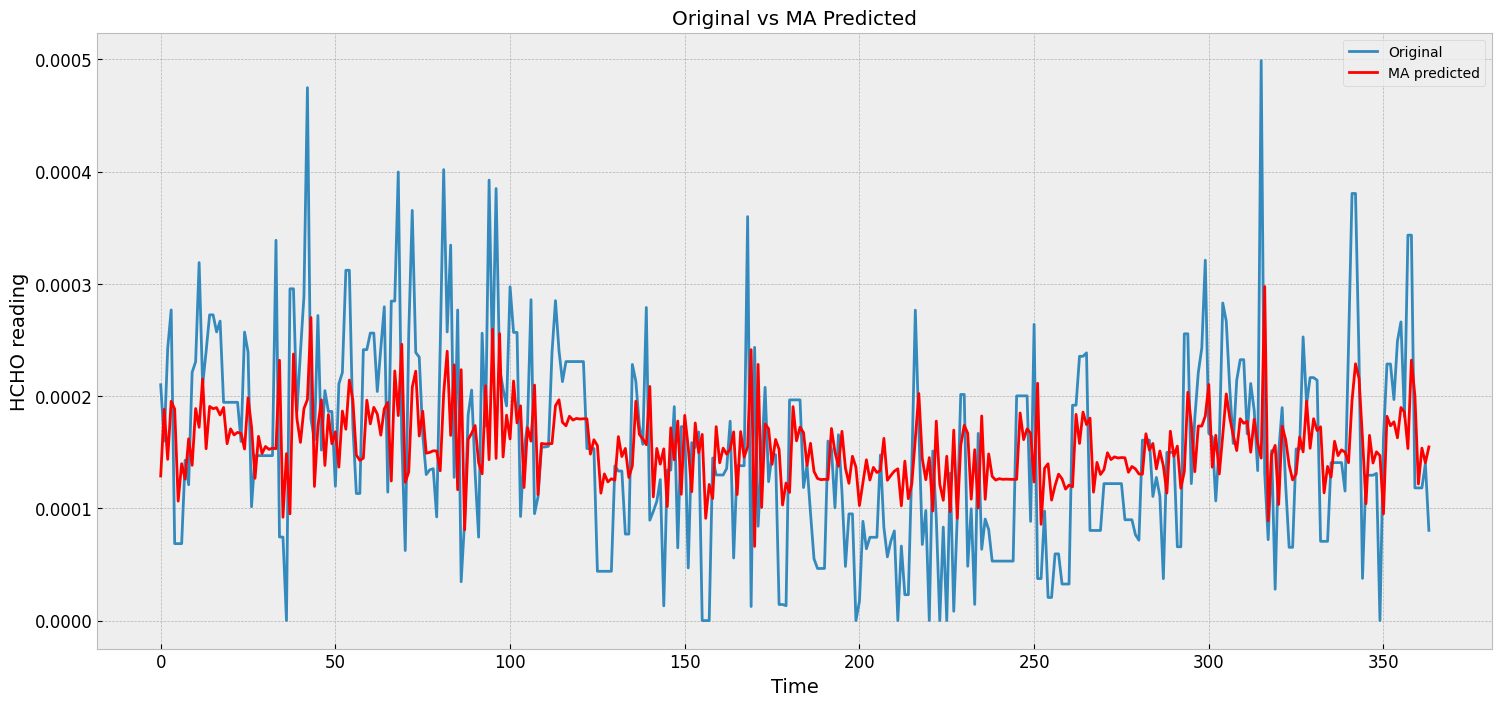

In [33]:
import matplotlib.pyplot as plt

# Plot the original data and the predicted values of Moving Average
plt.plot(colombo_test['HCHO reading'].values, label='Original')
plt.plot(yhat.values, color='red', label='MA predicted')
plt.legend()
plt.title('Original vs MA Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.show()


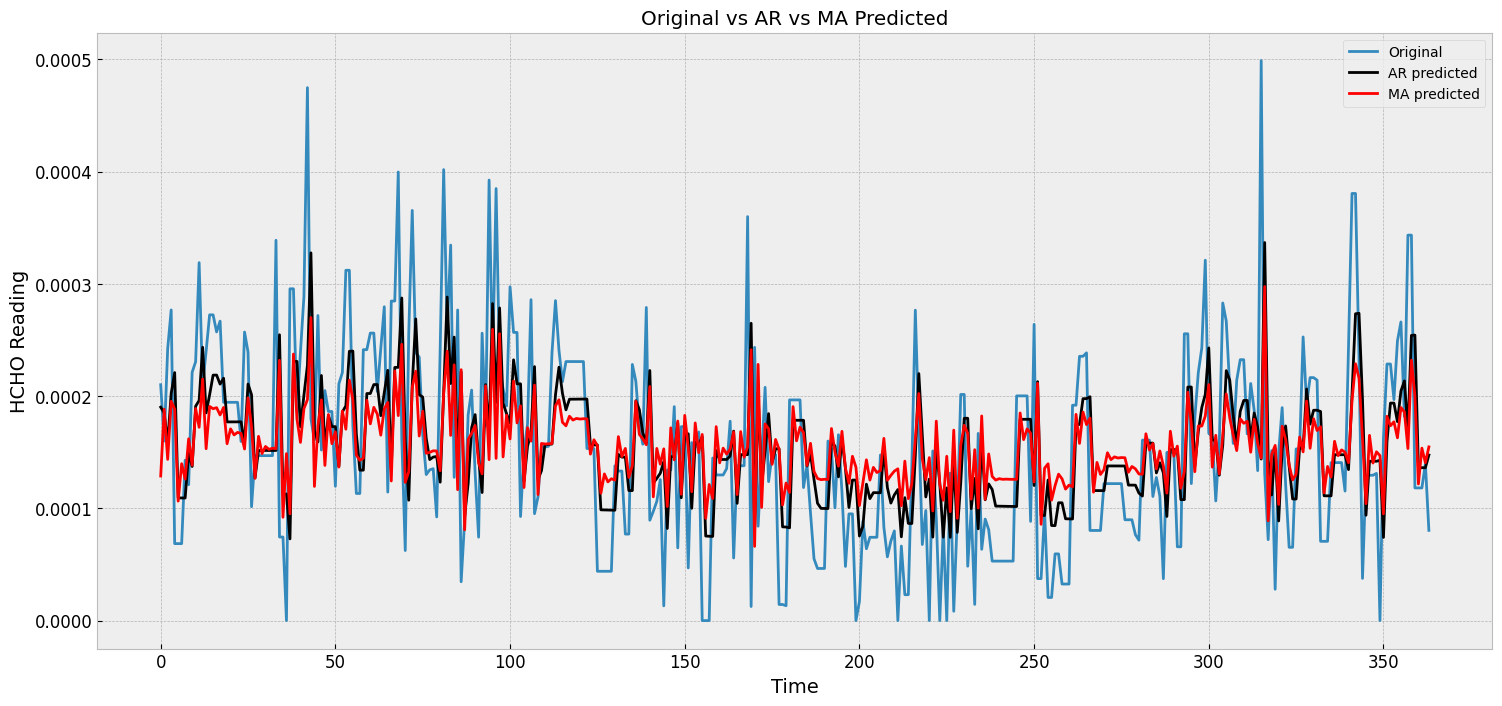

In [40]:
import matplotlib.pyplot as plt

# Plot the original data
plt.plot(colombo_test['HCHO reading'].values, label='Original')

# Plot the predicted values of Autoregression (AR)
plt.plot(predictionsDict['AR'].values, color='black', label='AR predicted')

# Plot the predicted values of Moving Average (MA)
plt.plot(predictionsDict['MA'].values, color='red', label='MA predicted')

# Add labels and legend
plt.title('Original vs AR vs MA Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO Reading')
plt.legend()

# Show the plot
plt.show()



In [41]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import matplotlib.pyplot as plt

# Assuming colombo_df is your DataFrame containing the 'HCHO reading' data

# ARIMA example
# Walk through the test data, training and predicting 1 day ahead for all the test data
index = len(colombo_training)
yhat = []

for t in tqdm(range(len(colombo_test['HCHO reading']))):
    temp_train = colombo_df['HCHO reading'][:len(colombo_training) + t]
    model = ARIMA(temp_train, order=(1, 0, 1))  # ARMA model with p=1, q=1
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=1)[0]
    yhat.append(predictions)

yhat = pd.Series(yhat, index=colombo_test.index)
resultsDict['ARMA'] = mean_squared_error(colombo_test['HCHO reading'], yhat)
predictionsDict['ARMA'] = yhat

100%|██████████| 364/364 [15:03<00:00,  2.48s/it]


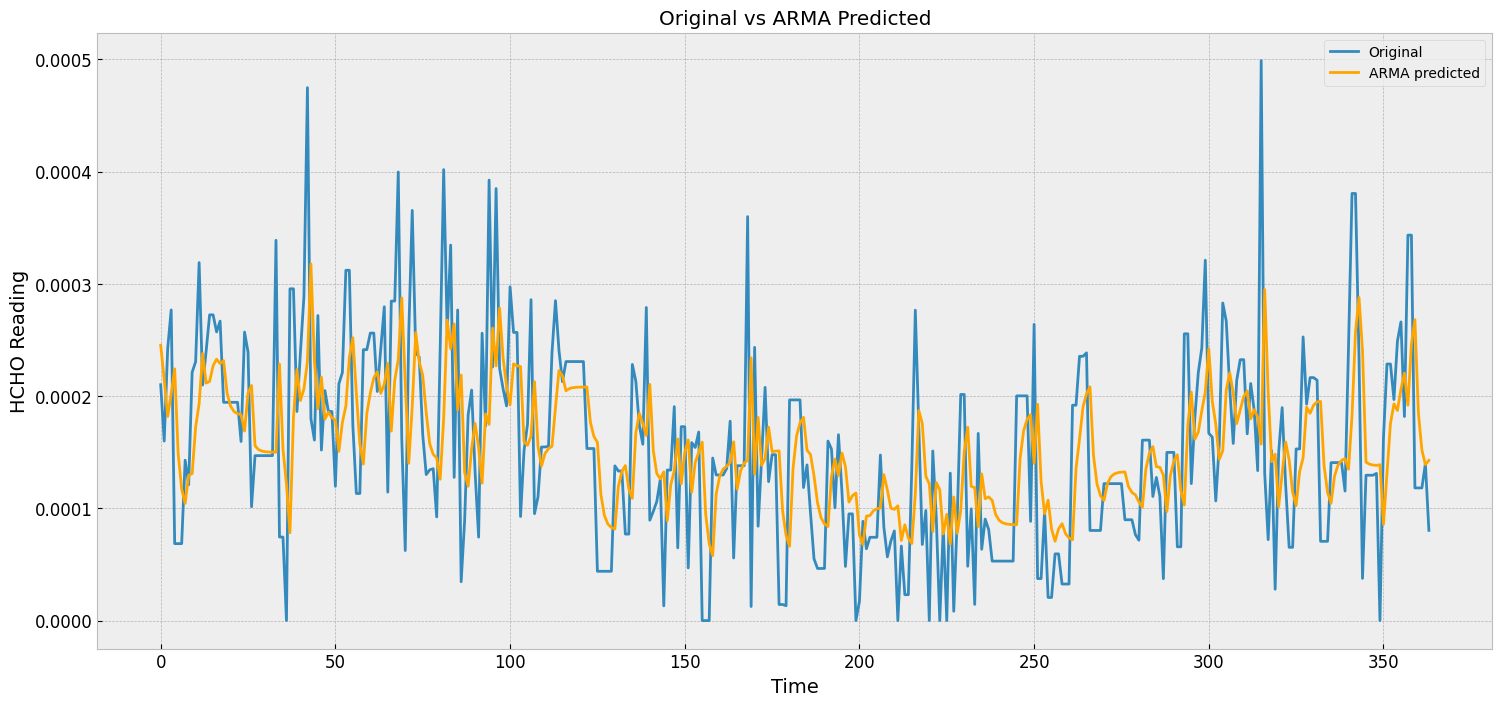

In [42]:
# Plot the results
plt.plot(colombo_test['HCHO reading'].values, label='Original')
plt.plot(yhat.values, color='orange', label='ARMA predicted')
plt.legend()
plt.title('Original vs ARMA Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO Reading')
plt.show()

In [43]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import matplotlib.pyplot as plt

# Assuming colombo_df is your DataFrame containing the 'HCHO reading' data

# ARIMA example
# Walk through the test data, training and predicting 1 day ahead for all the test data
index = len(colombo_training)
yhat = []

for t in tqdm(range(len(colombo_test['HCHO reading']))):
    temp_train = colombo_df['HCHO reading'][:len(colombo_training) + t]
    model = ARIMA(temp_train, order=(1, 1, 1))  # ARIMA model with p=1, d=1, q=1
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=1)[0]
    yhat.append(predictions)

yhat = pd.Series(yhat, index=colombo_test.index)
resultsDict['ARIMA'] = mean_squared_error(colombo_test['HCHO reading'], yhat)
predictionsDict['ARIMA'] = yhat

100%|██████████| 364/364 [09:18<00:00,  1.53s/it]


ValueError: Input contains NaN.

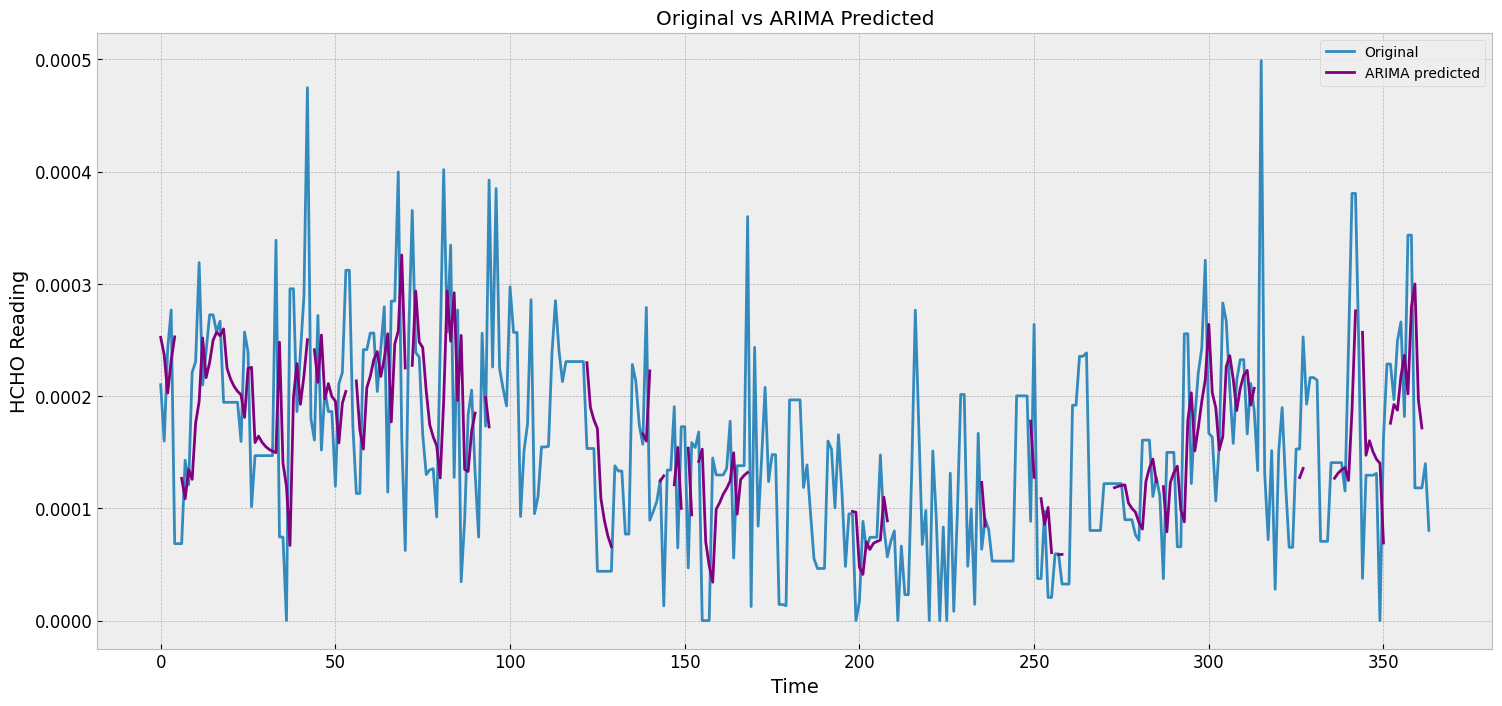

In [44]:
# Plot the results
plt.plot(colombo_test['HCHO reading'].values, label='Original')
plt.plot(yhat.values, color='purple', label='ARIMA predicted')
plt.legend()
plt.title('Original vs ARIMA Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO Reading')
plt.show()